# Benchmark for Community detection

 In this Benchmark we are using the LP Heuristic to label undirected Graphs.
 We start by importing dependencies.

In [1]:
"""Load/import helper functions"""
import itertools
import numbers
from LocalPopular import locally_popular_clustering_with_hop_distance, extract_labels_from_communities, time_tester, calculate_scores_CD

from GraphFunctions import generate_graph,randomize_graph_node_labels



import importlib
import PlotHelperFunctions
importlib.reload(PlotHelperFunctions)

from sklearn.metrics import rand_score
import networkx as nx

from community_detection.leiden import leiden
from community_detection.louvain import louvain
from community_detection.quality_functions import Modularity


import data.jazz as jazz
import data.cora as cora

## Create Graphs

For community detection, we used four different datasets.
- **Karate club**: a 34-node benchmark dataset for community detection.
- **Jazz musicians**: collaboration network of 198 jazz musicians; nodes represent musicians, edges represent co-membership in a band.
- **Cora dataset**: a citation network of 2708 machine learning papers classified into seven classes; edges denote citation links.
- **Random-25**: an instance containing 25 disjoint Erdős–Rényi graphs (10 nodes each, with p = 0.2) as communities; inter-community edges added independently with probability 0.05.

In [2]:
# Cora Dataset
cora_graph = cora.get_graph()
cora_graph = nx.relabel_nodes(cora_graph, {list(cora_graph.nodes())[i] : i for i in range(len(cora_graph.nodes()))} )
cora_truth = list(cora_graph.nodes[i]['subject'] for i in range(len(cora_graph.nodes())))

# Jazz Dataset
jazz_graph = jazz.get_graph()
jazz_graph = nx.relabel_nodes(jazz_graph, {i : i-1 for i in range(len(jazz_graph)+1)} )
jazz_truth = None

# Karate Club Dataset
karate_graph = nx.karate_club_graph()
karate_truth = list(karate_graph.nodes[i]["club"] for i in range(34))

# Erdos Renyi Graph
erdos_renyi_graph,erdos_renyi_truth = generate_graph(10,25,0.2,0.05)


## Run the algorithms

We will now run the LP Heuristic in several modes.
We will test the three introduced domains of FEN games:

- Friend-appreciating
- Enemy averse
- Balanced

Additionally for each mode we will run three different friendship-/enemy-thresholds:

- (0.2, 0.2)
- (0.25, 0.35)
- (0.4, 0.4)

These thresholds (a fraction that will be compared to the diameter of the Graph) will be used to create the friendship- and enemy-relation between data points.


Finally we will use different initial clusterings: 

- putting each agent into a singleton cluster (LocPop-S), 
- dividing agents randomly into k clusters where k is the predicted number of clusters (LocPop-P), and 
- using the output of the Leiden algorithm (LocPop-Ld).


We also run Louvian and Leiden for comparison

If you want to run this code yourself we suggest reducing the repetitions from 8 to 1.


In [3]:
import itertools
import timeit 
import pandas as pd
import numbers

dfs = []
labels = [(0.2,0.2),(0.25,0.35), (0.4,0.4)]

for treshold in labels:
    collected_data = {}
    for repetitions in range(8):
        f = treshold[0]   #f-bound
        e = treshold[1]   
    

        graphs = [karate_graph,cora_graph,jazz_graph,erdos_renyi_graph]
        expected_clusters = [2,7,None,25]
        graph_names = [ 'Karate Club','Cora', 'Jazz','Random-25']
        graph_truths =  [karate_truth,cora_truth,jazz_truth,erdos_renyi_truth]


        
        𝓗 = Modularity(1.0)
        
        fn_louvain_mod = lambda G,_: louvain(G, 𝓗)
        fn_leiden_mod  = lambda G,_: leiden(G, 𝓗)
        
        louv_out = None
        lei_out = None
        
        algorithms = [ fn_louvain_mod, fn_leiden_mod]
        algo_names = [ 'Louvain (Mod)', 'Leiden (Mod)']
        
        lp_a_b =lambda agents, initial_clustering, pre: locally_popular_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='B',pre = pre)
        lp_a_f =lambda agents, initial_clustering, pre: locally_popular_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='F',pre = pre)
        lp_a_e =lambda agents, initial_clustering, pre: locally_popular_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='E',pre = pre)
        
        algorithms = [ fn_louvain_mod, fn_leiden_mod,lp_a_b,lp_a_f,lp_a_e]
        algo_names = [ 'Louvain (Mod)', 'Leiden (Mod)','LP (Balanced) Heuristic',\
                       'LP (Friend-Oriented) Heuristic','LP (Enemy-Averse) Heuristic']
        is_lp_heuristic = [False,False,True, True, True]
        
        
        for ((graph, g_name,clusters,truth), (algo, a_name,lp_heuristic)) in \
            itertools.product(zip(graphs, graph_names, expected_clusters,graph_truths), zip(algorithms, algo_names,is_lp_heuristic)):
            
            graph, truth = randomize_graph_node_labels(graph,truth)
            graph = [graph]
            truth = [truth]
              
            agents = []
            for i in range(len(graph)):
                agents += [list(graph[i].nodes())]
        
        
            if lp_heuristic:
                # start with everyone alone
                a_name_modified = a_name + ' starting with everyone alone'
                initial_clusters = len(agents[0])
                if g_name == 'Cora':
                    a_name_modified += ' *6 starting clusters'
                    initial_clusters = 6
                
                test_callable = lambda a: algo(a,initial_clusters,None)
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
        
                
                # starting with predicted number of clusters
                a_name_modified = a_name + ' starting with predicted number of clusters'
                initial_clusters = clusters
                
                test_callable = lambda a: algo(a,initial_clusters,None)
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
        
                
                # start with the output of leiden
                a_name_modified = a_name + ' starting with the output of leiden'
                initial_clusters = clusters
                
                test_callable = lambda a: algo(a,initial_clusters,fn_leiden_mod)
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
        
                rand_score_with_init = sum(rand_score(list(out.values()), list(lei.values())) for out, lei in zip(outputs, lei_output)) / len(outputs)
                scores['Rand Score with initial clustering'] = rand_score_with_init
                
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
        
               
        
            else:
                test_callable = lambda a : algo(a,_)
                times,outputs = time_tester(test_callable,graph)
                outputs = [extract_labels_from_communities(c.communities) for c in outputs]
        
                if algo == fn_leiden_mod:
                    lei_output = outputs
                    
                
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
                scores['Time'] = avg_time
                if (a_name, g_name) not in collected_data:
                    collected_data[(a_name, g_name)] = []
                collected_data[(a_name, g_name)].append(scores)
        
    records = []
    for (method, dataset), metrics_list in collected_data.items():
        record = {'Method': method, 'Dataset': dataset}
        keys = metrics_list[0].keys()
        for key in keys:
            values = [m[key] for m in metrics_list if isinstance(m[key], numbers.Number)]
            if values:
                mean = sum(values) / len(values)
                std = (sum((v - mean) ** 2 for v in values) / len(values)) ** 0.5
                record[key] = (mean, std)
            else:
                record[key] = metrics_list[0][key]  # fallback for non-numeric
        records.append(record)
    
    df = pd.DataFrame(records)
    
    dfs.append(df)


Quick check for the maximum standard deviation of the scores.

In [4]:
# Get maximum standart deviations
max_stds = {}

for df in dfs:
    for col in ['Rand Index', 'Modularity']:
        stds = df[col].apply(lambda x: x[1] if isinstance(x, (tuple, list)) else float('nan'))
        max_stds[col] = max(max_stds.get(col, float('-inf')), stds.max())

print(max_stds)

{'Rand Index': np.float64(0.03428767212419136), 'Modularity': np.float64(0.10607896278737408)}


## Printing Figures


Figure saved as ./figures/PopularCommunity/Karate Club-Rand Index.png


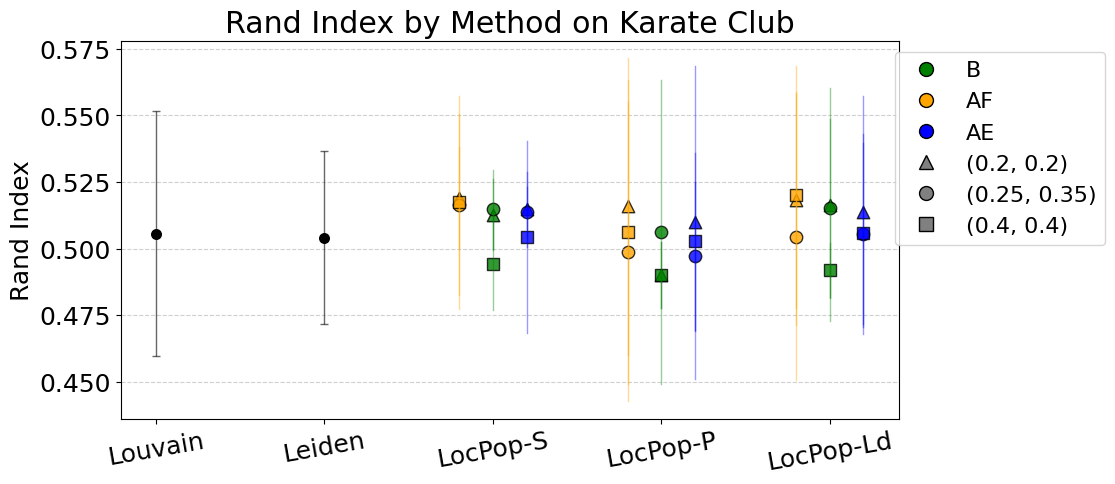

Figure saved as ./figures/PopularCommunity/Karate Club-Modularity.png


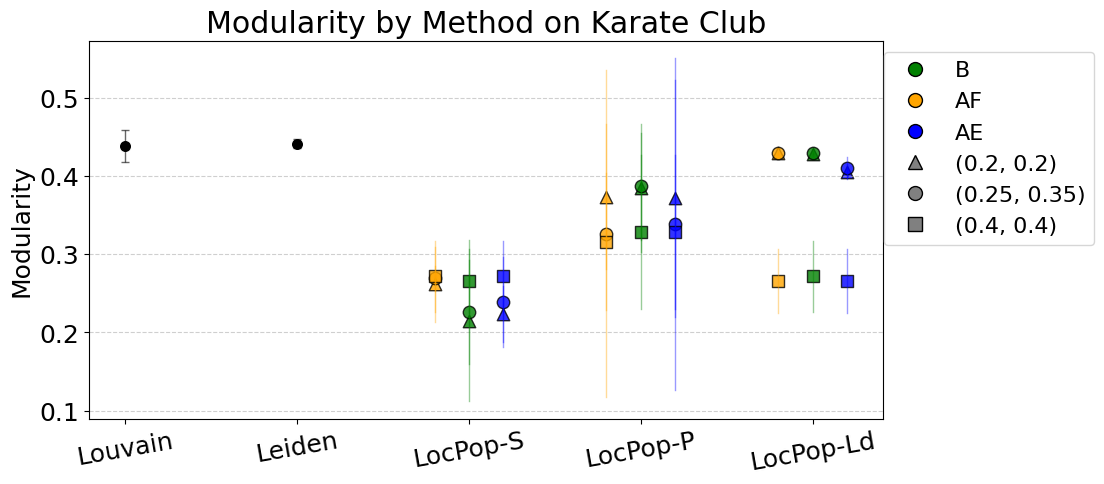

Figure saved as ./figures/PopularCommunity/Cora-Rand Index.png


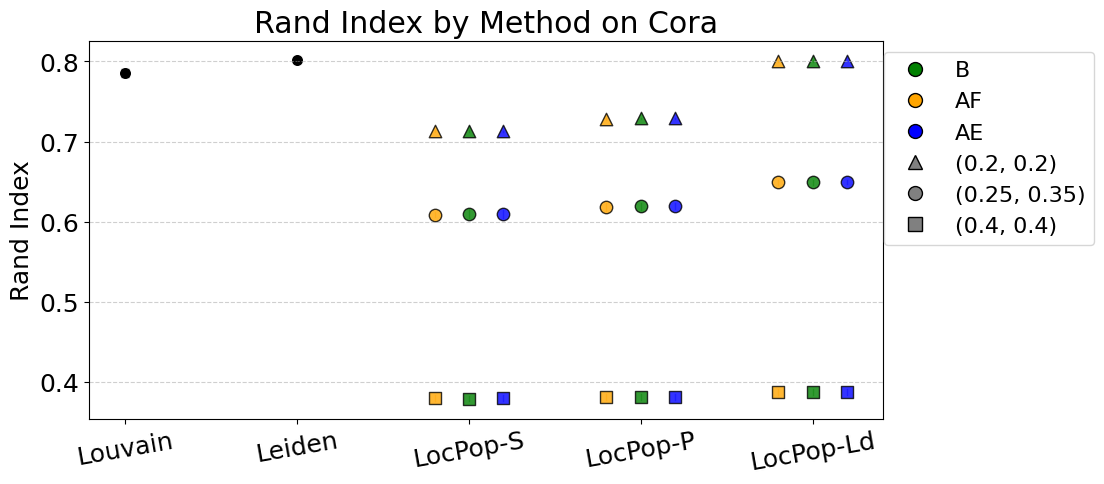

Figure saved as ./figures/PopularCommunity/Cora-Modularity.png


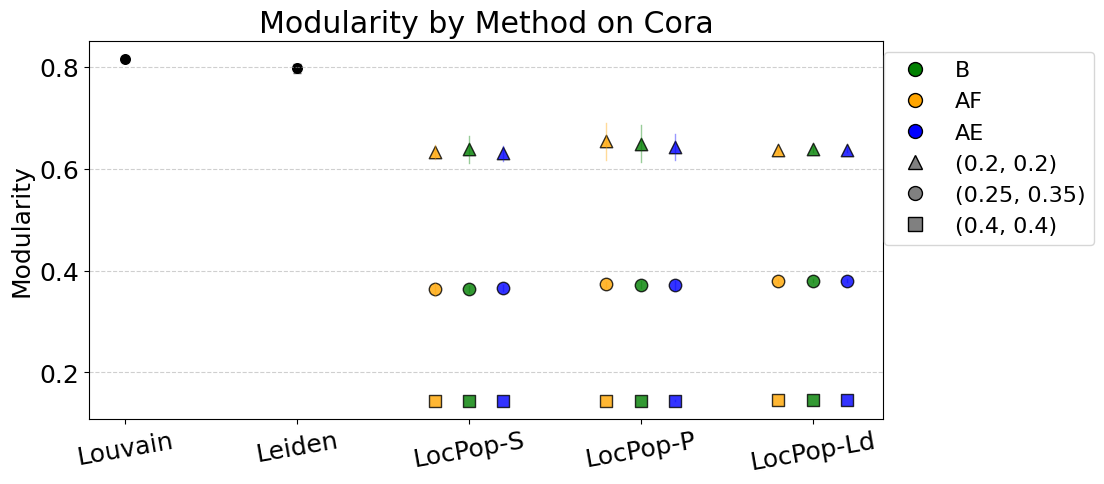

Figure saved as ./figures/PopularCommunity/Jazz-Rand Index.png


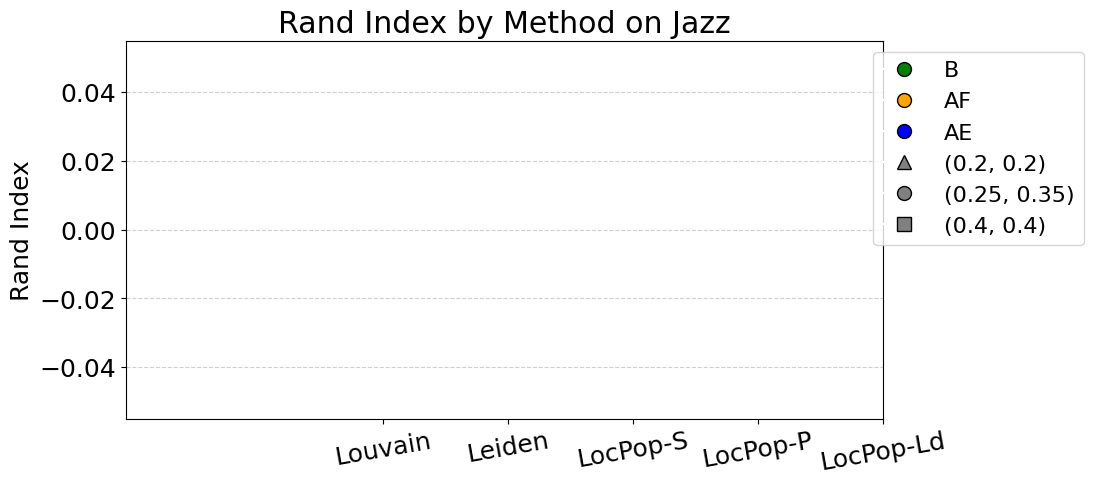

Figure saved as ./figures/PopularCommunity/Jazz-Modularity.png


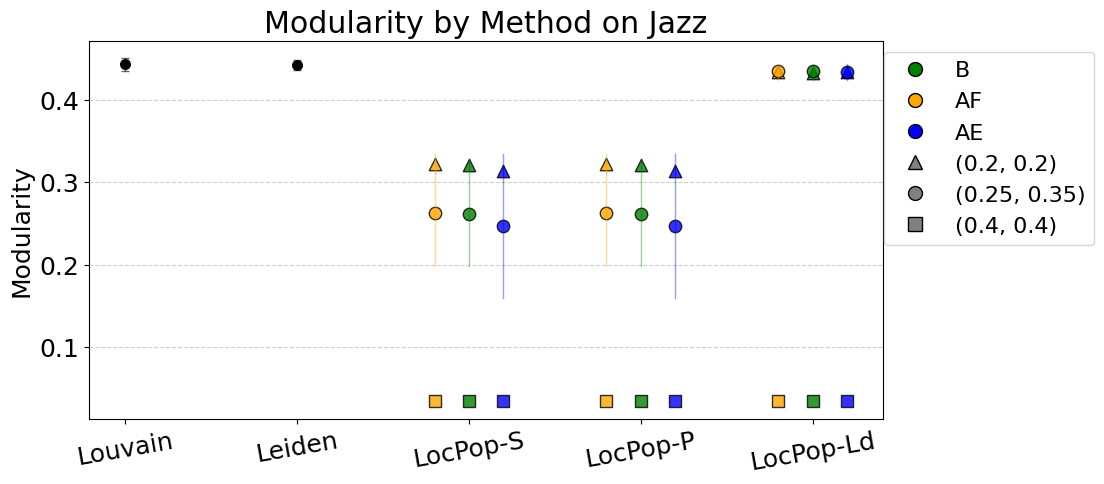

Figure saved as ./figures/PopularCommunity/Random-25-Rand Index.png


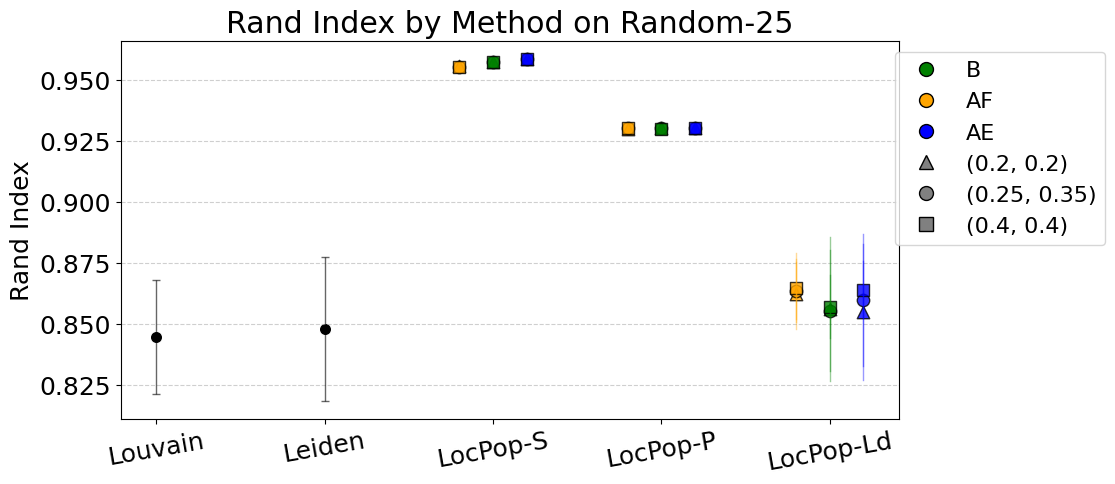

Figure saved as ./figures/PopularCommunity/Random-25-Modularity.png


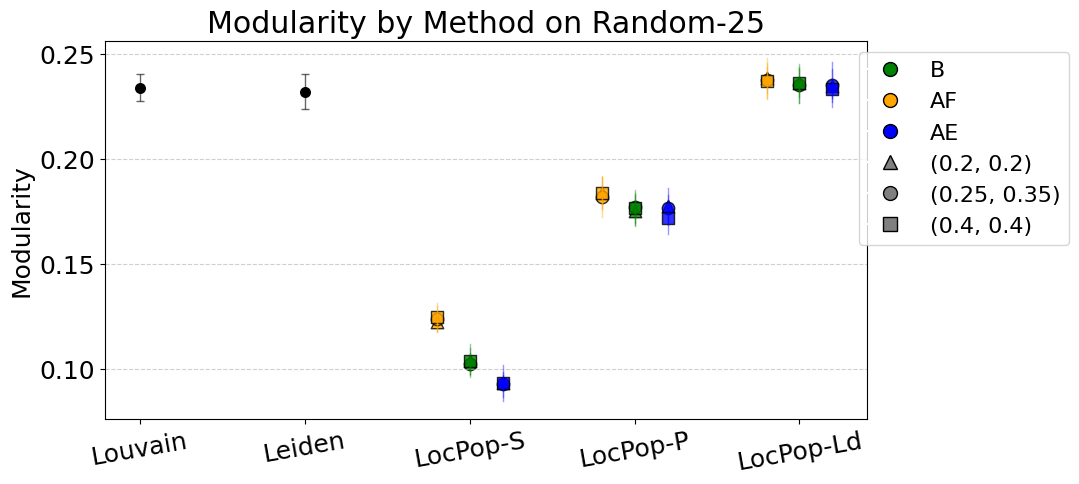

In [5]:

score_cols = ['Rand Index', 'Modularity']

labels = [(0.2,0.2), (0.25,0.35),(0.4,0.4)]
# Then call your plotting
for Dataset in [ 'Karate Club','Cora', 'Jazz','Random-25']:
    for score in score_cols:
        PlotHelperFunctions.plot_and_save_community(
            dfs, labels, Dataset, score, mode = "LP",
            save_path=f'./figures/PopularCommunity/{Dataset}-{score}.png'
        )

In [6]:
import ast
import numpy as np
import pandas as pd

# Compute the mean Rand Scores with the initial clustering

all_values = []

for df in dfs:
    col = 'Rand Score with initial clustering'
    if col in df.columns:
        values = df[col].apply(
            lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('(')
            else x[0] if isinstance(x, (tuple, list))
            else float('nan')
        )
        all_values.extend(values.dropna().tolist())

# Convert to numpy array for convenience
all_values = np.array(all_values)

# Compute min, max, and average, ignoring NaNs
min_val = np.nanmin(all_values)
max_val = np.nanmax(all_values)
avg_val = np.nanmean(all_values)

print(f"Min: {min_val}")
print(f"Max: {max_val}")
print(f"Average: {avg_val}")


Min: 0.33419313623686936
Max: 0.9423037966015129
Average: 0.6470515078741435


## Saving the dataframe as csv

In [7]:
for i,df in enumerate(dfs):
    df.to_csv(f'./csv/PopularCommunity/dataset-{i}.csv')